In [781]:
from datetime import datetime
import numpy as np
from enum import Enum


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from  sklearn.metrics import mean_squared_error


import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller


import meteostat

g_figsize = (25,15)

class MeteostatInterval(Enum):
    HOURLY = 1
    DAILY = 2
    MONTHLY = 3
    YEARLY = 4


# get the weather data from map coordinates using the meteostat weather python api
# https://dev.meteostat.net/python/#installation
def get_weather_data(longitude, latitude, elevation, start_time, end_time, value_names=['tavg', 'tmin', 'tmax'], intervals = MeteostatInterval.DAILY):
    # Set time period
    # Create Point for Vancouver, BC
    location_coords = meteostat.Point(longitude, latitude, elevation)

    # Get daily data for 2018
    if intervals == MeteostatInterval.DAILY :
        data = meteostat.Daily(location_coords, start_time, end_time)
    elif intervals == MeteostatInterval.HOURLY :
        data = meteostat.Hourly(location_coords, start_time, end_time)
    elif intervals == MeteostatInterval.MONTHLY :
        data = meteostat.Monthly(location_coords, start_time, end_time)
    elif intervals == MeteostatInterval.YEARLY :
        data = meteostat.Yearly(location_coords, start_time, end_time)
    
    data = data.fetch()

    # Drop all columns except for the one mentioned in the parameter value_names
    data.drop(labels = data.columns.difference(value_names), axis = 1, inplace=True)
    
    return data


# Plot the data
def plot_data(df, title='Remaining Passenger Number after modelling Trend and Seasonality', filename = None):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    ax = df.plot(figsize=g_figsize)
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if filename is not None:
        plt.savefig(f'{filename}.svg')
    plt.show()
    return ax

def to_date_format(x):
    final_date = x[:4] + "-" + x[4:6] + "-" + x[6:8]
    return final_date
    

def get_temperature_df(file_path):
    

    df = pd.read_csv(file_path, sep=",", header = 14)

    temp_df = pd.DataFrame(columns={'date', target_label})

    temp_df['date'] = df['    DATE']
    temp_df[target_label] = df['   TG']/10.0

    temp_df['date'] = temp_df['date'].astype(str)

    temp_df['date'] = temp_df['date'].apply(to_date_format)
    temp_df['date'] = pd.to_datetime(temp_df['date'])

    temp_df.set_index('date', inplace=True)

    return temp_df


def get_previous_year_temp(date , years_duration, df):
    return df.loc[pd.to_datetime(date + years_duration * pd.Timedelta(days=365))]

def get_mean_temperature(date, years, df):
    temp_mean = 0

    for year in range(1, years + 1):
        temp_mean += get_previous_year_temp(date, year, df)
        temp_mean += get_previous_year_temp(date, -year, df)
        
    return temp_mean/(2 * years)

def impute_range_mean(df_limit, missing_value, years):

    missing_dates = pd.Series(df_limit.loc[df_limit[target_label] < missing_value].index.values)
    missing_temperatures = missing_dates.apply(get_mean_temperature, args=(years,df_limit))

    df_limit_copy = df_limit.copy()
    df_limit_copy.loc[df_limit[target_label] < missing_value] = missing_temperatures.values

    return df_limit_copy


def plot_resampled_temperatures(df, target_label, interval_type = 'Y', xaxis_labels_freq = None):

    if interval_type == 'D':
        df_resampled = df
        y = df_resampled[target_label].values
        temperature_column_label = target_label
    else :

        # For interval types Year and Month discard the means of Intervals which are partial
        # for example in this case as 2021 year is partial its mean will be discarded.
        # discarding partial bins taken from _
        # https://stackoverflow.com/questions/50272670/pandas-0-22-resample-only-full-bins-drop-partials
        df_resampled = df.resample(interval_type).agg({target_label:['mean','count']})
        df_resampled.columns = df_resampled.columns.map('_'.join)

        if(interval_type == 'Y'):
            df_resampled = df_resampled.query(f'{target_label}_count == 365')
        if(interval_type == 'M'):
            df_resampled = df_resampled.query(f'{target_label}_count == 30 or {target_label}_count == 31 or {target_label}_count == 28 or {target_label}_count == 29')
        y = df_resampled[f'{target_label}_mean'].values
        temperature_column_label = f'{target_label}_mean'

    length = len(df_resampled)
    df_resampled = df_resampled.assign(timestep=list(range(length)))

    X = df_resampled['timestep'].values
    X = sm.add_constant(X)

    model = sm.OLS(y,X)
    results = model.fit()

    slopes = np.full((len(X),2), [results.params[0], results.params[1]])
    y_plot = np.sum(X*slopes, axis=1)

    fig, ax = plt.subplots(figsize=g_figsize)

    if xaxis_labels_freq is not None :
        # Set the ticks of time intervals to show on the x axis
        # taken from https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-with-matplotlib/introduction-to-matplotlib-plots/plot-time-series-data-in-python/
        ax.xaxis.set_major_locator(xaxis_labels_freq)
    # sns.lineplot(data=df_resampled, y=temperature_column_label, x='date', ax=ax)
    sns.lineplot(data=df_resampled, y=temperature_column_label, x=df_resampled.index, ax=ax)
    sns.lineplot(y=y_plot, x=df_resampled.index, ax=ax)


def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=1; CI=99%) 
            {round(levels['5%'],2)} (p=5; CI=95%)
            {round(levels['10%'],2)} (p=10 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)



In [782]:

# Use this when data is extracted from https://www.ecad.eu/dailydata/index.php csv files
target_label = 'mean_temperature'
temp_df = get_temperature_df("data/BerlinTempelhofMeanTemperature/TG_STAID002759.txt")
temp_df = impute_range_mean(temp_df, -998, 3)


# split the date into test and train
temp_df_test = temp_df.loc['2021-01-01' : temp_df.index[-1]]
temp_df = temp_df.loc['2000-01-01' : '2020-12-31']


# Use this to get weather data for any location coords using meteostat python api
# Interlaken town map coordinates 46.686348, 7.863205, 576
# derived from https://www.maps.ie/coordinates.html
# target_label = 'tavg'
# temp_df = get_weather_data(46.686348, 7.863205, 576, datetime(1980, 1, 1), datetime(2022, 1, 31), [target_label])
# getting the dates which have missing target label values
# is_NaN = temp_df.isnull()
# row_has_NaN = is_NaN.any(axis=1)
# rows_with_NaN = temp_df[row_has_NaN]
# rows_with_NaN



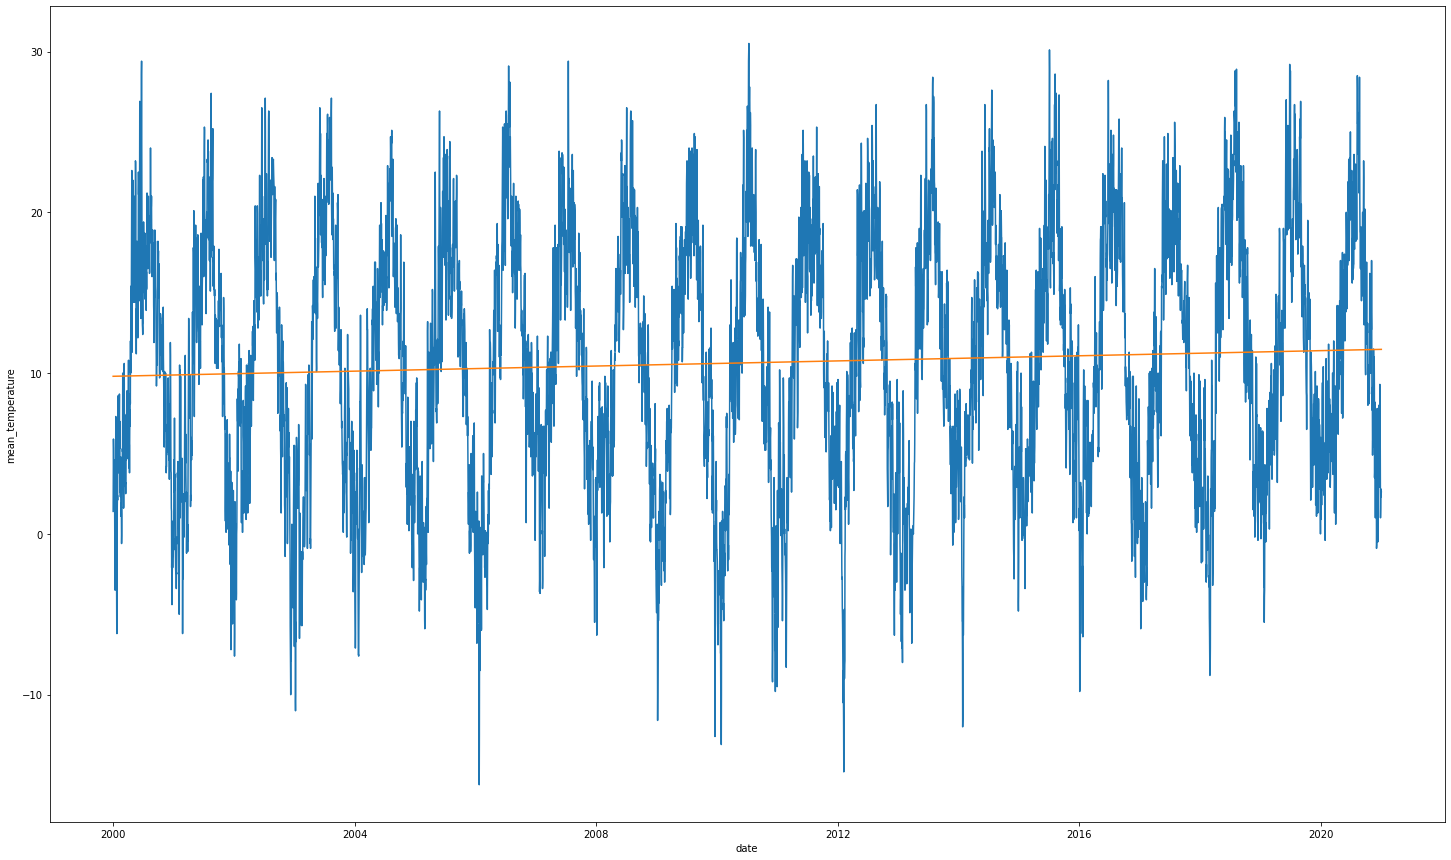

In [783]:


# fill it with previous target label values
# temp_df.fillna(method = 'pad', inplace=True)

plot_resampled_temperatures(temp_df,target_label, 'D')

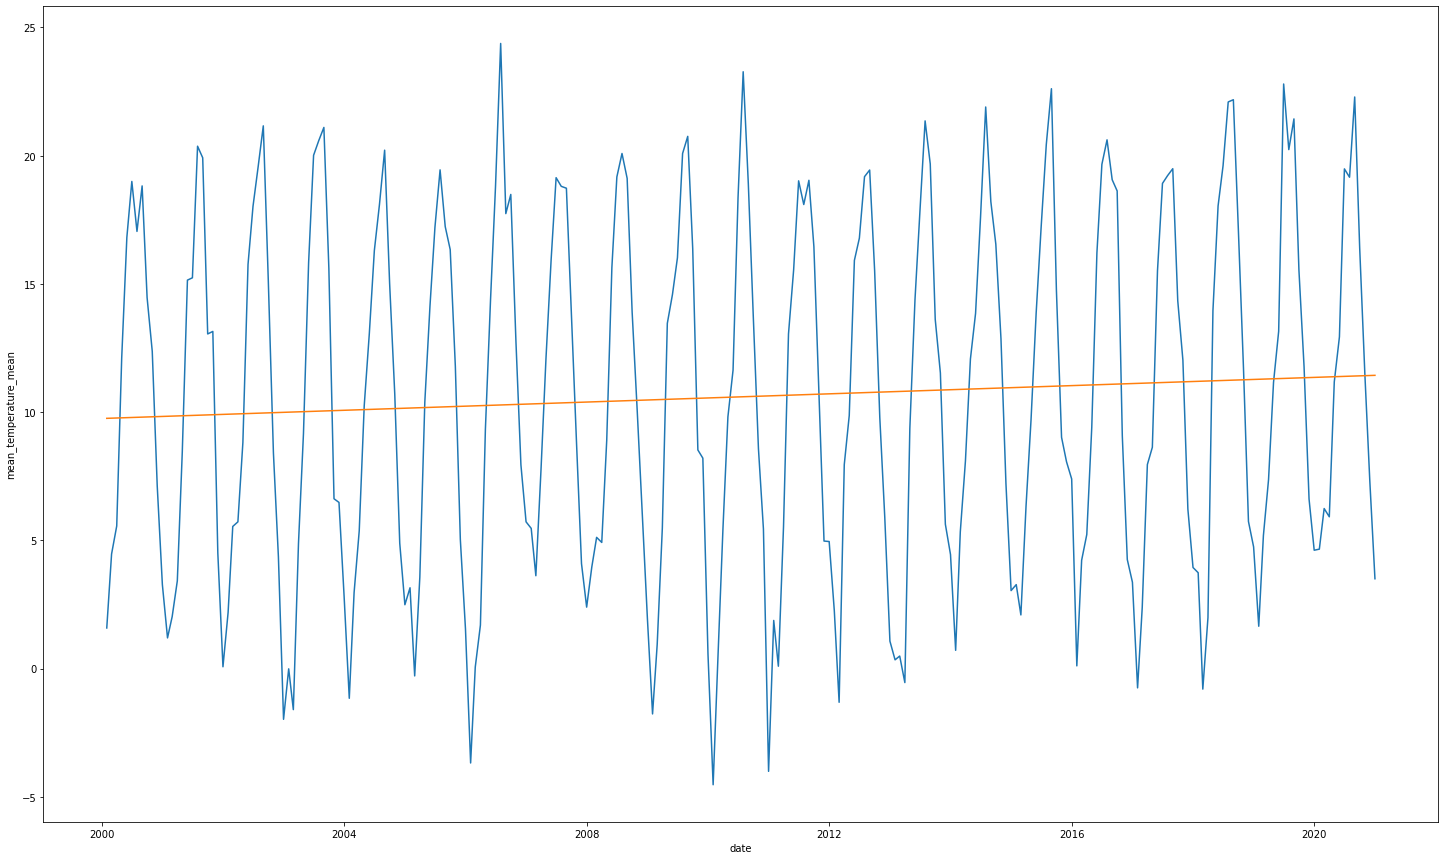

In [784]:
plot_resampled_temperatures(temp_df, target_label, 'M')

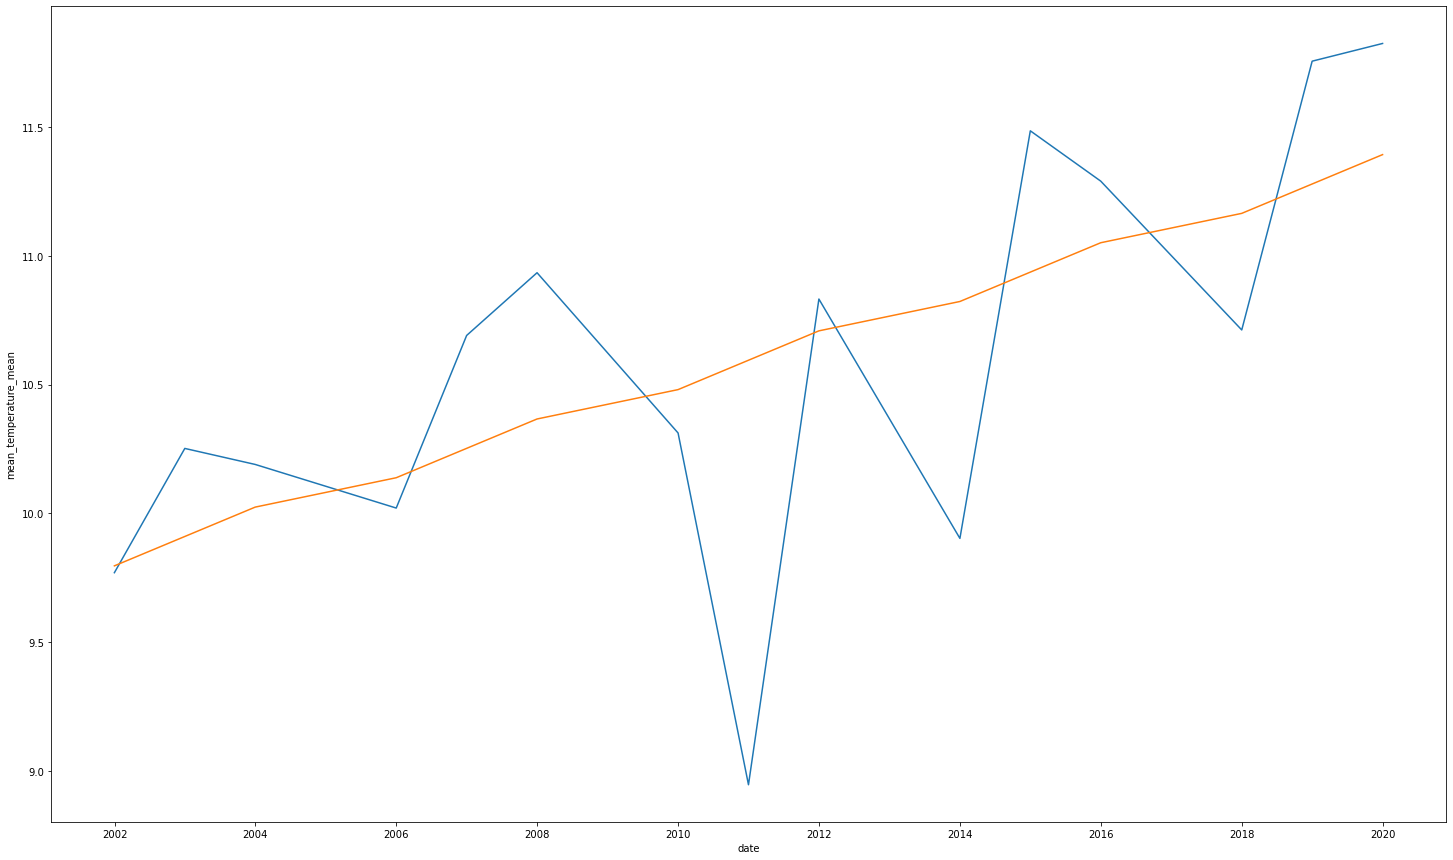

In [785]:

plot_resampled_temperatures(temp_df, target_label)

In [786]:
# temp_decade_years_df = temp_df.loc['2010-01-01':'2020-12-31']

# plot_resampled_temperatures(temp_decade_years_df, target_label, 'M', mdates.YearLocator())

In [787]:

# Get the trend feature
temp_df['timestep'] = list(range(len(temp_df)))
# m = LinearRegression()
# X = temp_df[['timestep']]
# y = temp_df[target_label]

# m.fit(X, y)

# temp_df['trend'] = m.predict(X)

In [788]:

# Add months features for seasonal changes
seasonal_dummies = pd.get_dummies(temp_df.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(temp_df.index)

temp_df = temp_df.join(seasonal_dummies)

temp_df.tail()


,mean_temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
2020-12-27,1.6,7666,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,2.8,7667,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,2.3,7668,0,0,0,0,0,0,0,0,0,0,1
2020-12-30,2.5,7669,0,0,0,0,0,0,0,0,0,0,1
2020-12-31,2.6,7670,0,0,0,0,0,0,0,0,0,0,1


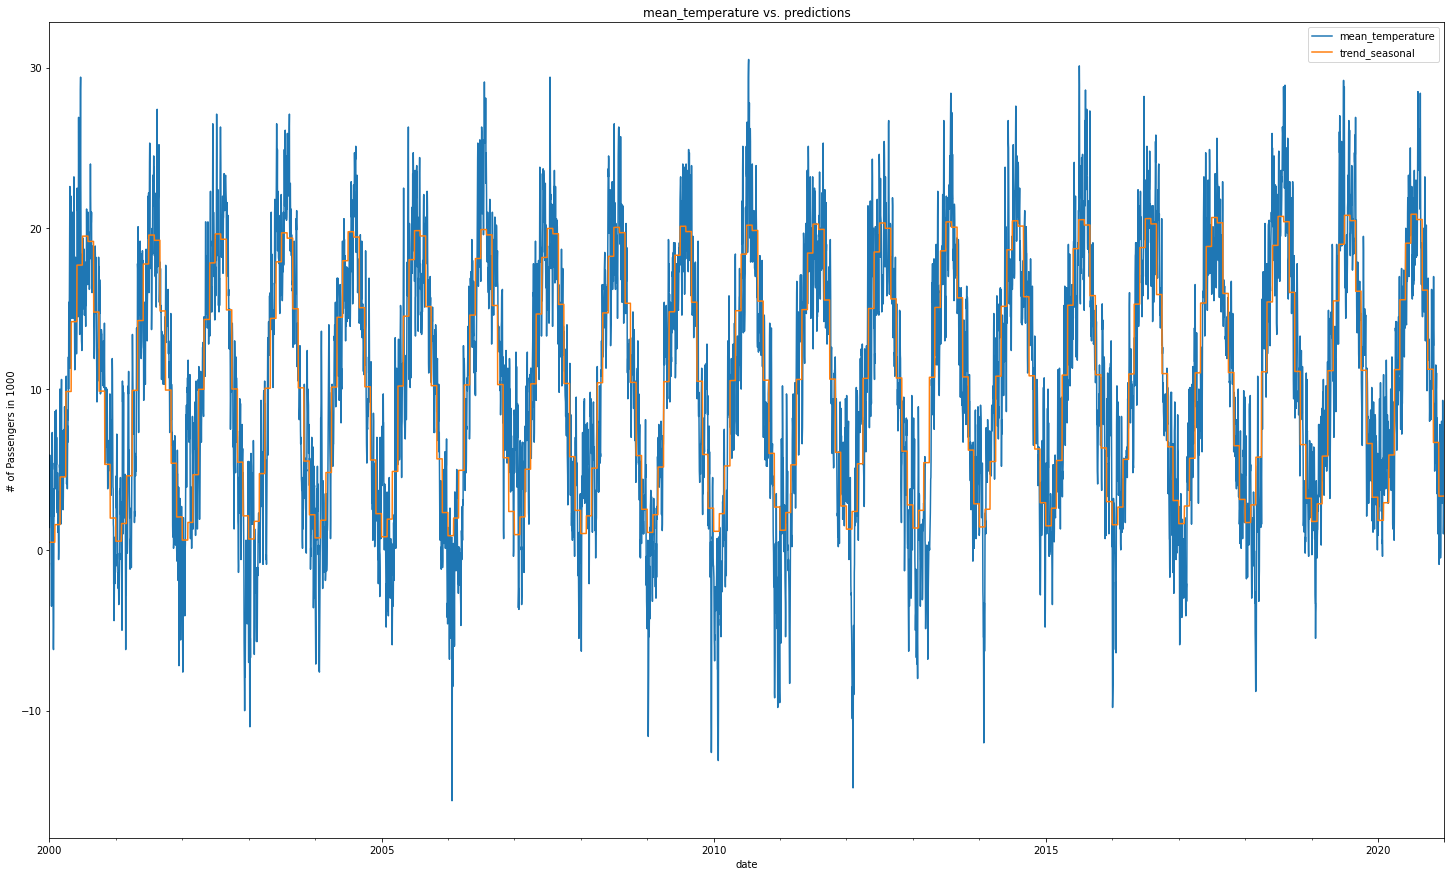

<AxesSubplot:title={'center':'mean_temperature vs. predictions'}, xlabel='date', ylabel='# of Passengers in 1000'>

In [789]:
# Predict the seasonal trends
X = temp_df.drop(columns=[target_label])
y = temp_df[target_label]

m_trend_seasonal = LinearRegression()
m_trend_seasonal.fit(X, y)

temp_df['trend_seasonal'] = m_trend_seasonal.predict(X)

plot_data(temp_df[[target_label, 'trend_seasonal']], title='mean_temperature vs. predictions')


In [790]:
# Get the remainder
temp_df['remainder'] = temp_df[target_label] - temp_df['trend_seasonal']


In [791]:
# Determine the number of lags to consider 
selected_order = ar_select_order(temp_df['remainder'], maxlag=20)
selected_order.ar_lags # tells us to use 4 lag

lags = [1,2]

In [792]:
# Add lags features
for lag in lags:
    temp_df[f'lag{lag}'] = temp_df['remainder'].shift(lag)

# temp_df.dropna(inplace=True)
temp_df.fillna(method='bfill', inplace=True)

temp_df.head()

,mean_temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2
date,,,,,,,,,,,,,,,,,
2000-01-01,1.4,0,0,0,0,0,0,0,0,0,0,0,0,0.471672,0.928328,0.928328,0.928328
2000-01-02,3.9,1,0,0,0,0,0,0,0,0,0,0,0,0.471859,3.428141,0.928328,0.928328
2000-01-03,5.9,2,0,0,0,0,0,0,0,0,0,0,0,0.472045,5.427955,3.428141,0.928328
2000-01-04,5.3,3,0,0,0,0,0,0,0,0,0,0,0,0.472232,4.827768,5.427955,3.428141
2000-01-05,3.0,4,0,0,0,0,0,0,0,0,0,0,0,0.472418,2.527582,4.827768,5.427955


In [793]:


X = temp_df.drop(columns=[target_label, 'trend_seasonal', 'remainder'])
y = temp_df[target_label]

m_linear = LinearRegression()
m_linear.fit(X, y)

LinearRegression()

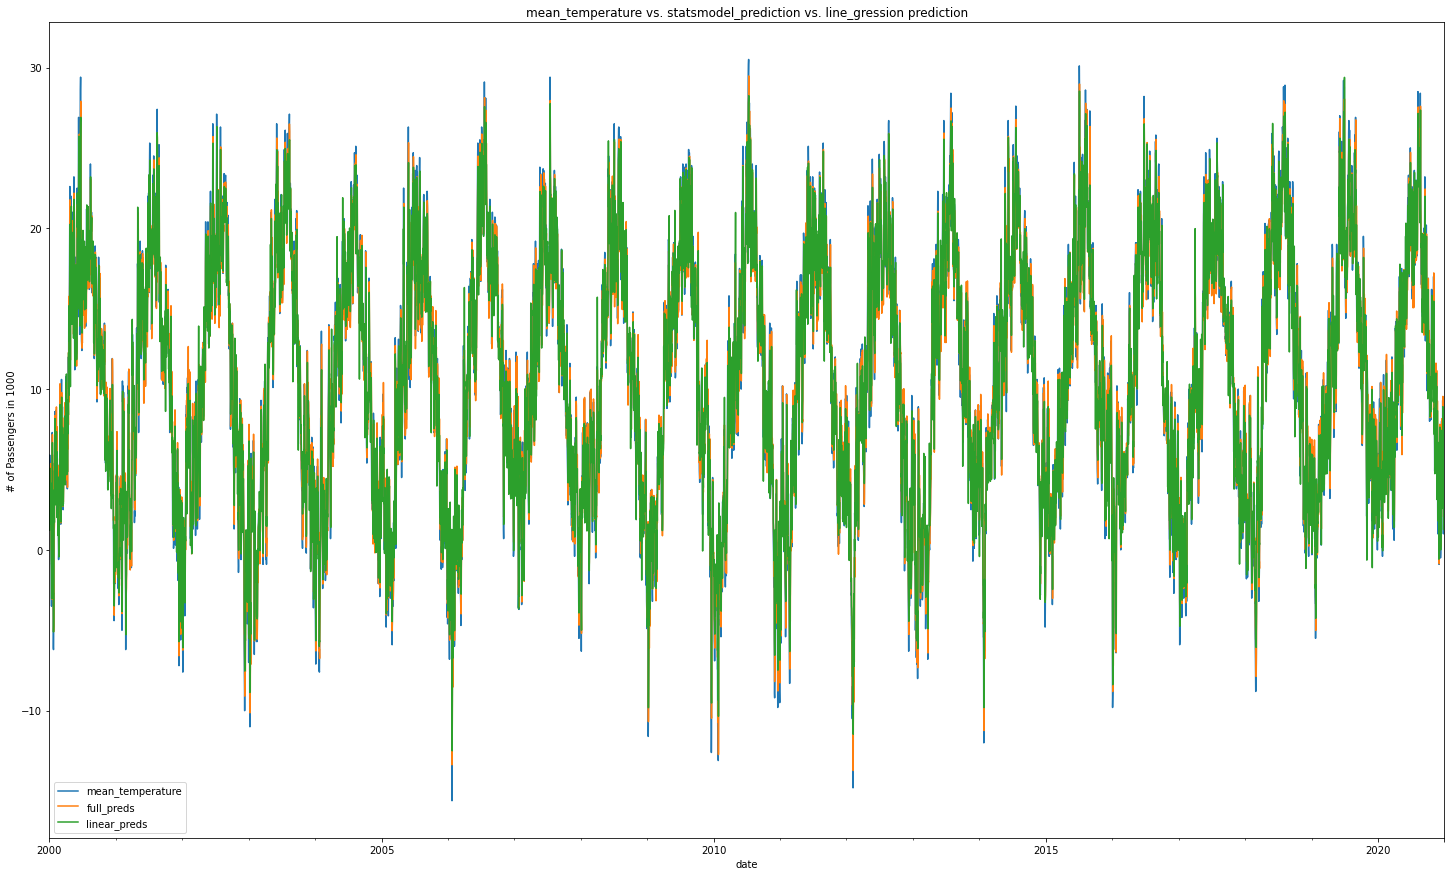

<AxesSubplot:title={'center':'mean_temperature vs. statsmodel_prediction vs. line_gression prediction'}, xlabel='date', ylabel='# of Passengers in 1000'>

In [794]:

# Compare the linear regression, stats models and real values
statsmodels_ar = AutoReg(temp_df[target_label], lags=4, trend='ct', seasonal=True).fit()
temp_df['full_preds'] = statsmodels_ar.predict()
temp_df['linear_preds'] = m_linear.predict(X)
plot_data(temp_df[[target_label, 'full_preds', 'linear_preds']], title='mean_temperature vs. statsmodel_prediction vs. line_gression prediction')


In [795]:
# Plot the previous decade
# temp_df_limit = temp_df.loc['2010-01-01':'2021-12-31']
# plot_data(temp_df_limit[[target_label, 'full_preds', 'linear_preds']], title='mean_temperature vs. predictions')

In [796]:
#Perform the time series cross validation
X = temp_df.drop([target_label, 'trend_seasonal', 'remainder', 'full_preds', 'linear_preds'], axis=1)

y = temp_df[target_label]

ts_split = TimeSeriesSplit(n_splits=5) # instanciate the class and give the k as input
time_cv = ts_split.split(X, y) # this is a python generator

estimator = LinearRegression()

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.92649699 0.91515094 0.9251359  0.91474868 0.91461662]
0.9192298246473557


In [797]:
first_test_timestep = temp_df['timestep'][-1] + 1

temp_df_test['timestep'] = list(range(first_test_timestep,first_test_timestep + len(temp_df_test)))

seasonal_dummies = pd.get_dummies(temp_df_test.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(temp_df_test.index)

temp_df_test = temp_df_test.join(seasonal_dummies)

temp_df_test.head()

,mean_temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
2021-01-01,2.1,7671,0,0,0,0,0,0,0,0,0,0,0
2021-01-02,1.1,7672,0,0,0,0,0,0,0,0,0,0,0
2021-01-03,0.6,7673,0,0,0,0,0,0,0,0,0,0,0
2021-01-04,0.8,7674,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,1.7,7675,0,0,0,0,0,0,0,0,0,0,0


In [798]:
temp_df_test['trend_seasonal'] = m_trend_seasonal.predict(temp_df_test.drop(target_label, axis=1))
temp_df_test['remainder'] = temp_df_test[target_label] - temp_df_test['trend_seasonal']

In [799]:
# assign the four lags
for lag in lags:
    if lag == 1:

        temp_df_test[f'lag{lag}'] = temp_df_test['remainder'].shift(1)
        temp_df_test.loc[temp_df_test.index[0], 'lag1'] = temp_df.loc[temp_df.index[-1], 'remainder']
    else :
        temp_df_test[f'lag{lag}'] = temp_df_test[f'lag{lag-1}'].shift(1)
        temp_df_test.loc[temp_df_test.index[0], f'lag{lag}'] = temp_df.loc[temp_df.index[-1], f'lag{lag-1}']

temp_df.tail()

,mean_temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,full_preds,linear_preds
date,,,,,,,,,,,,,,,,,,,
2020-12-27,1.6,7666,0,0,0,0,0,0,0,0,0,0,1,3.346169,-1.746169,-2.345982,-0.645796,2.050152,1.256344
2020-12-28,2.8,7667,0,0,0,0,0,0,0,0,0,0,1,3.346355,-0.546355,-1.746169,-2.345982,2.750293,2.150665
2020-12-29,2.3,7668,0,0,0,0,0,0,0,0,0,0,1,3.346542,-1.046542,-0.546355,-1.746169,3.248656,3.193772
2020-12-30,2.5,7669,0,0,0,0,0,0,0,0,0,0,1,3.346728,-0.846728,-1.046542,-0.546355,2.256607,2.488962
2020-12-31,2.6,7670,0,0,0,0,0,0,0,0,0,0,1,3.346915,-0.746915,-0.846728,-1.046542,2.898774,2.774672


In [800]:
temp_df_test.head()

,mean_temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2
date,,,,,,,,,,,,,,,,,
2021-01-01,2.1,7671,0,0,0,0,0,0,0,0,0,0,0,1.902382,0.197618,-0.746915,-0.846728
2021-01-02,1.1,7672,0,0,0,0,0,0,0,0,0,0,0,1.902569,-0.802569,0.197618,-0.746915
2021-01-03,0.6,7673,0,0,0,0,0,0,0,0,0,0,0,1.902755,-1.302755,-0.802569,0.197618
2021-01-04,0.8,7674,0,0,0,0,0,0,0,0,0,0,0,1.902942,-1.102942,-1.302755,-0.802569
2021-01-05,1.7,7675,0,0,0,0,0,0,0,0,0,0,0,1.903128,-0.203128,-1.102942,-1.302755


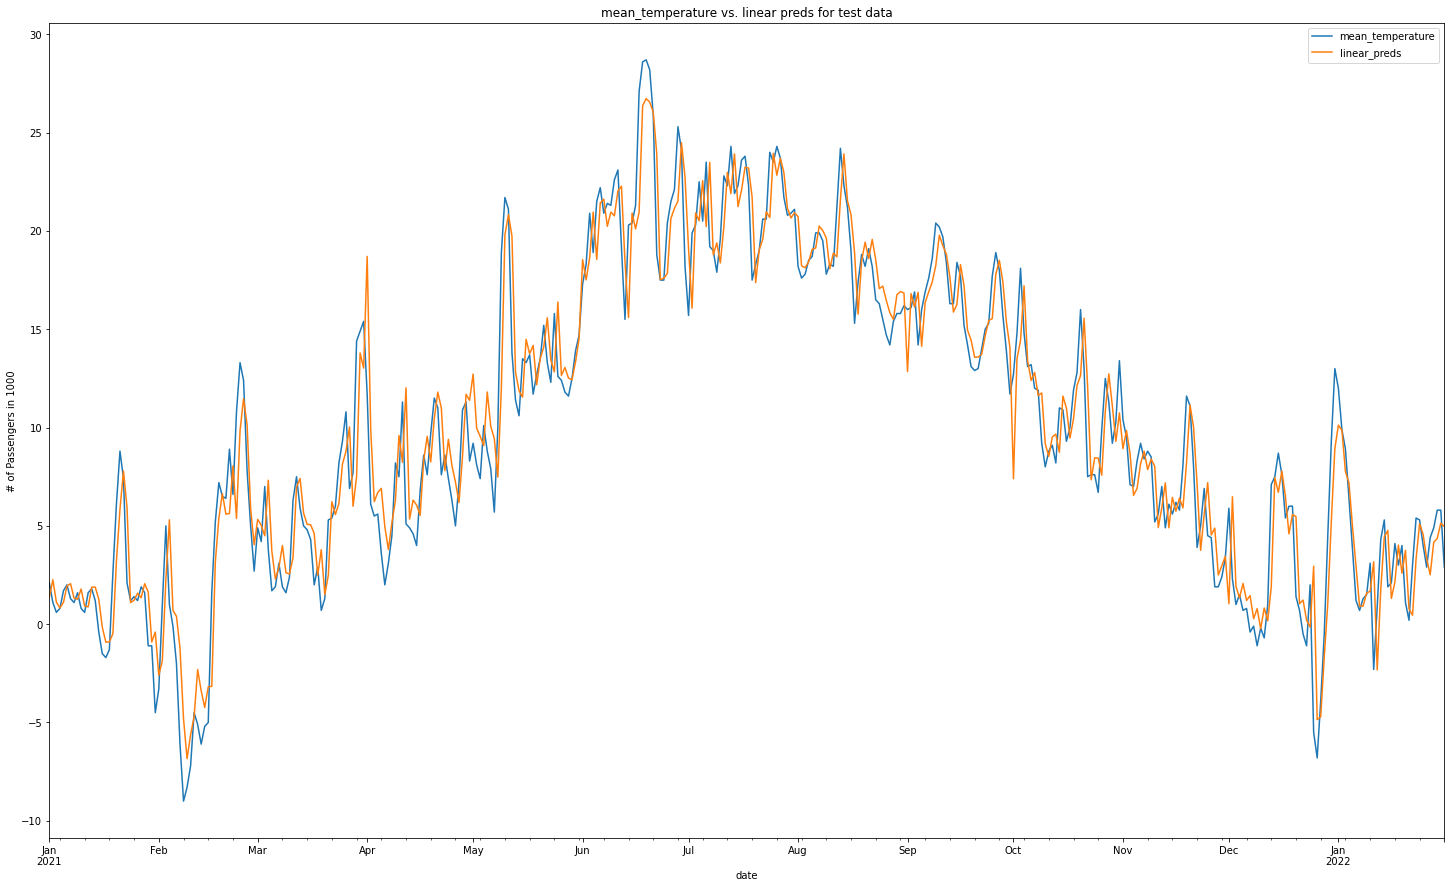

<AxesSubplot:title={'center':'mean_temperature vs. linear preds for test data'}, xlabel='date', ylabel='# of Passengers in 1000'>

In [801]:
X_test = temp_df_test.drop(['mean_temperature','trend_seasonal','remainder'], axis=1)

temp_df_test['linear_preds'] = m_linear.predict(X_test)

plot_data(temp_df_test[[target_label, 'linear_preds']], title='mean_temperature vs. linear preds for test data')

In [802]:
np.sqrt(mean_squared_error(temp_df_test['linear_preds'], temp_df_test[target_label]))



2.141182273808863

In [803]:
r2_score(temp_df_test['linear_preds'], temp_df_test[target_label])


0.9199581195025232

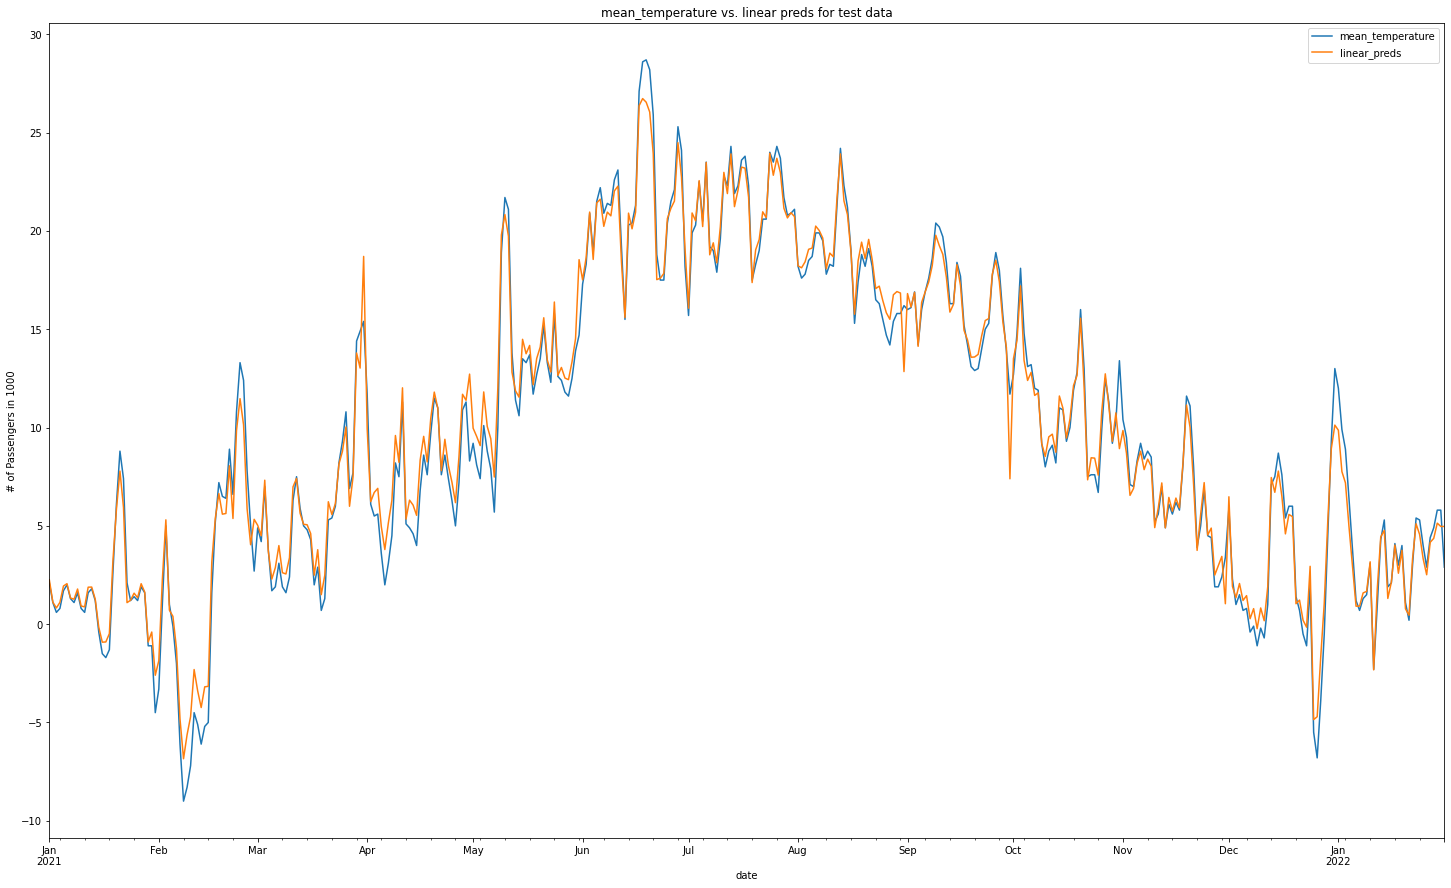

<AxesSubplot:title={'center':'mean_temperature vs. linear preds for test data'}, xlabel='date', ylabel='# of Passengers in 1000'>

In [804]:
temp_df_test['linear_preds'] = temp_df_test['linear_preds'].shift(-1)
temp_df_test.fillna(method='ffill', inplace=True)
plot_data(temp_df_test[[target_label, 'linear_preds']], title='mean_temperature vs. linear preds for test data')

In [805]:

np.sqrt(mean_squared_error(temp_df_test['linear_preds'], temp_df_test[target_label]))


1.0023538898639017

In [806]:
r2_score(temp_df_test['linear_preds'], temp_df_test[target_label])


0.9824202192952718

In [807]:
# Check if the remainder is stationary
print_adf(temp_df['remainder'])

   
            adf: -23.45
            p: 0.0 
            used lag: 5 
            number of observations: 7665
            -3.43 (p=1; CI=99%) 
            -2.86 (p=5; CI=95%)
            -2.57 (p=10 CI=90%) 
            information criterion (AIC): 33599.54221030597
            


In [808]:
# # As adf fuller p is less than 0.05 we can reject that the remainder is non stationary 

# # Find the differencing term to use for the remainder
# # Original Series
# fig, axes = plt.subplots(4, 1, sharex=True, figsize=g_figsize)
# temp_df[['remainder']].plot(ax=axes[0], title='Original Series')

# # 1st Differencing
# temp_df[['remainder']].diff().plot(ax=axes[1], title='1st Order Differencing')

# # 2nd Differencing
# temp_df[['remainder']].diff().diff().plot(ax=axes[2], title='2nd Order Differencing')

# # 3rd Differencing
# temp_df[['remainder']].diff().diff().diff().plot(ax=axes[3], title='3rd Order Differencing')
# plt.show()

# # Plot the partial auto corralation
# # Original Series
# fig, axes = plt.subplots(4, 1, sharex=True, figsize=g_figsize)
# plot_acf(temp_df['remainder'], ax=axes[0], title='No differencing')

# # 1st Differencing
# plot_acf(temp_df['remainder'].diff().dropna(), ax=axes[1], title='Differencing 1')

# # 2nd Differencing
# plot_acf(temp_df['remainder'].diff().diff().dropna(), ax=axes[2], title='Differencing 2')

# # 3nd Differencing
# plot_acf(temp_df['remainder'].diff().diff().dropna(), ax=axes[3], title='Differencing 3')

# plt.show()

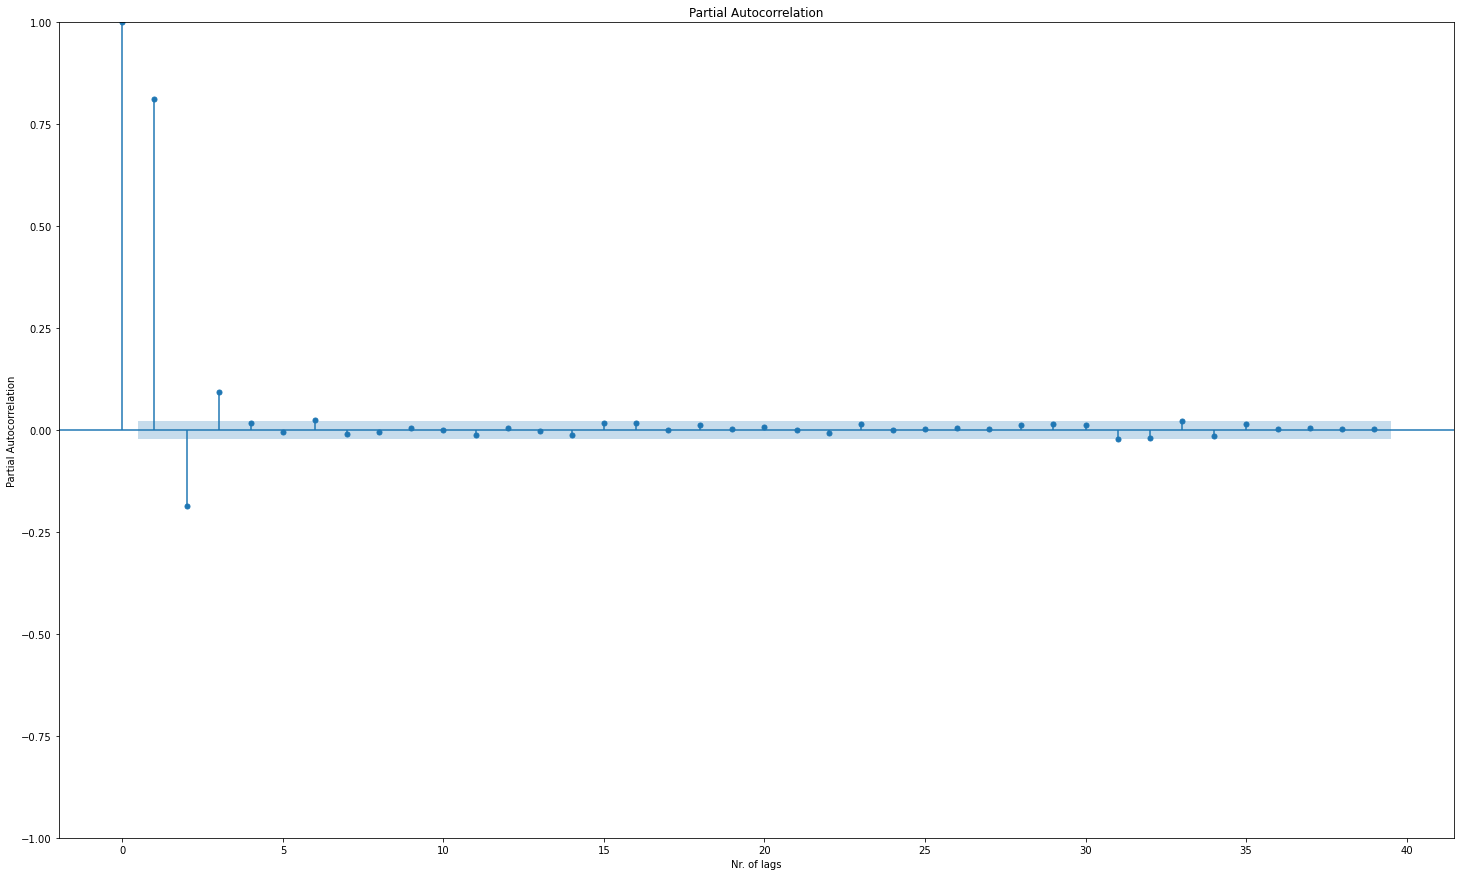

In [809]:
# to determine the p in arima we need to check partial autocorrolation
# Determine the auto correlations of the remainder with different lags
# This is needed to capture the dependency on the previous time values
# in this case it is previous days 
with plt.rc_context():
    plt.rc("figure", figsize=g_figsize)
    plot_pacf(temp_df['remainder'])
    plt.xlabel('Nr. of lags')
    plt.ylabel('Partial Autocorrelation')


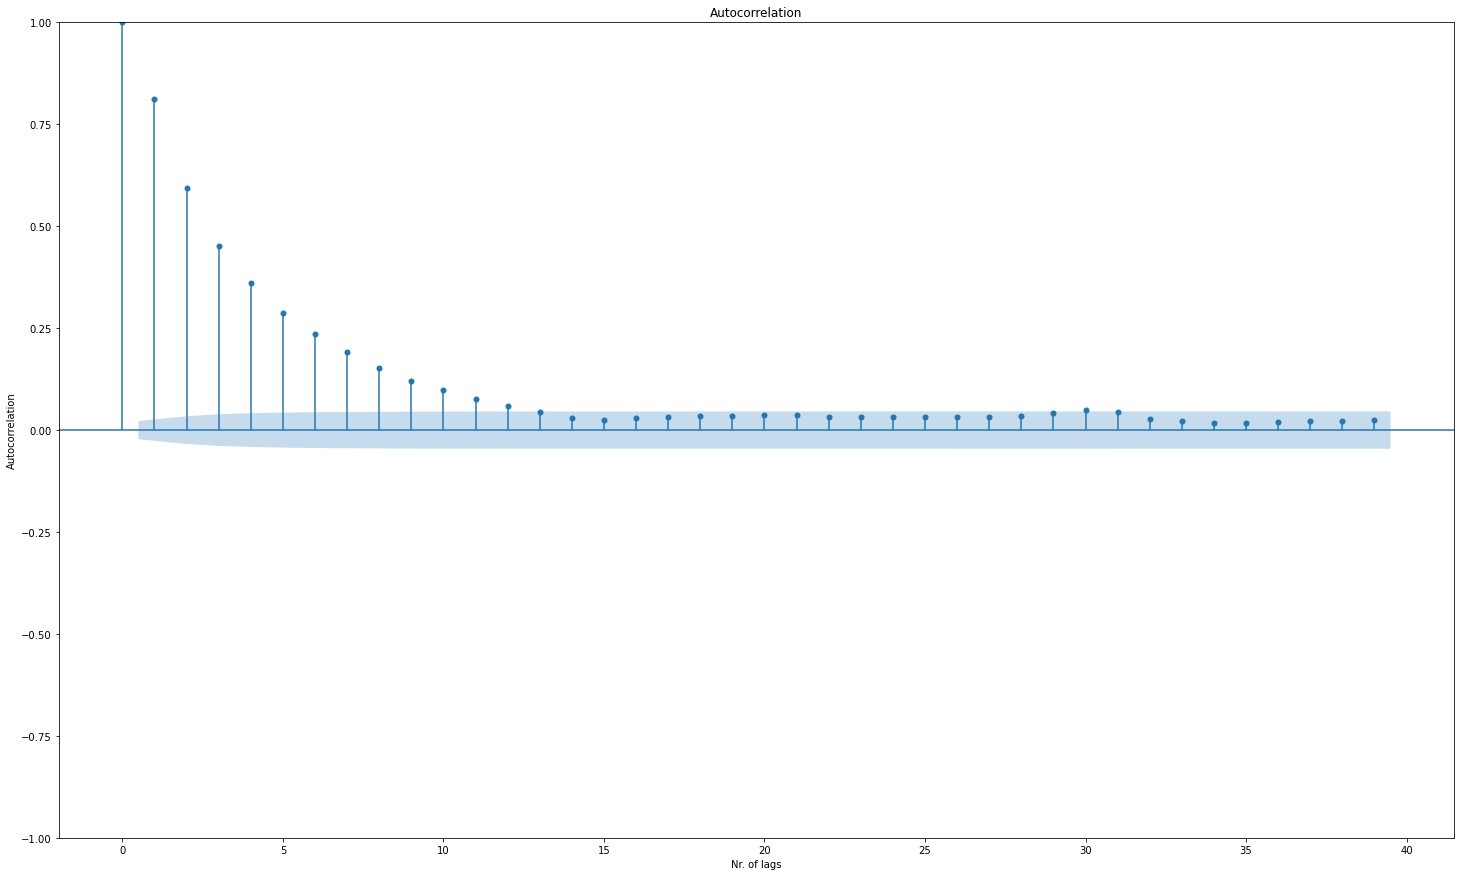

In [810]:
# Determine the auto corrolation for the chosen diffeence
# consider the q to the number of lags which have values greater 
# than
with plt.rc_context():
    plt.rc("figure", figsize=g_figsize)
    plot_acf(temp_df['remainder'])
    plt.xlabel('Nr. of lags')
    plt.ylabel('Autocorrelation')

In [811]:
# ARIMA Model (p,d,q) = (p,0,10)
arima_model = ARIMA(temp_df[['remainder']], order=(1, 0, 3)).fit()
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                 7671
Model:                 ARIMA(1, 0, 3)   Log Likelihood              -16882.103
Date:                Sun, 27 Feb 2022   AIC                          33776.205
Time:                        01:41:51   BIC                          33817.876
Sample:                    01-01-2000   HQIC                         33790.498
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.993e-05      0.127      0.000      1.000      -0.248       0.248
ar.L1          0.8004      0.014     56.100      0.000       0.772       0.828
ma.L1          0.1785      0.019      9.631      0.000       0.142       0.215
ma.L2         -0.0993      0.019     -5.310      0.000      -0.136      -0.063
ma.L3         -0.0716      0.014     -4.964      0.000      -0.100      -0.043
sigma2         4.7755      0.069     69.568      0.000       4.641       4.910
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               142.82
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.07
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

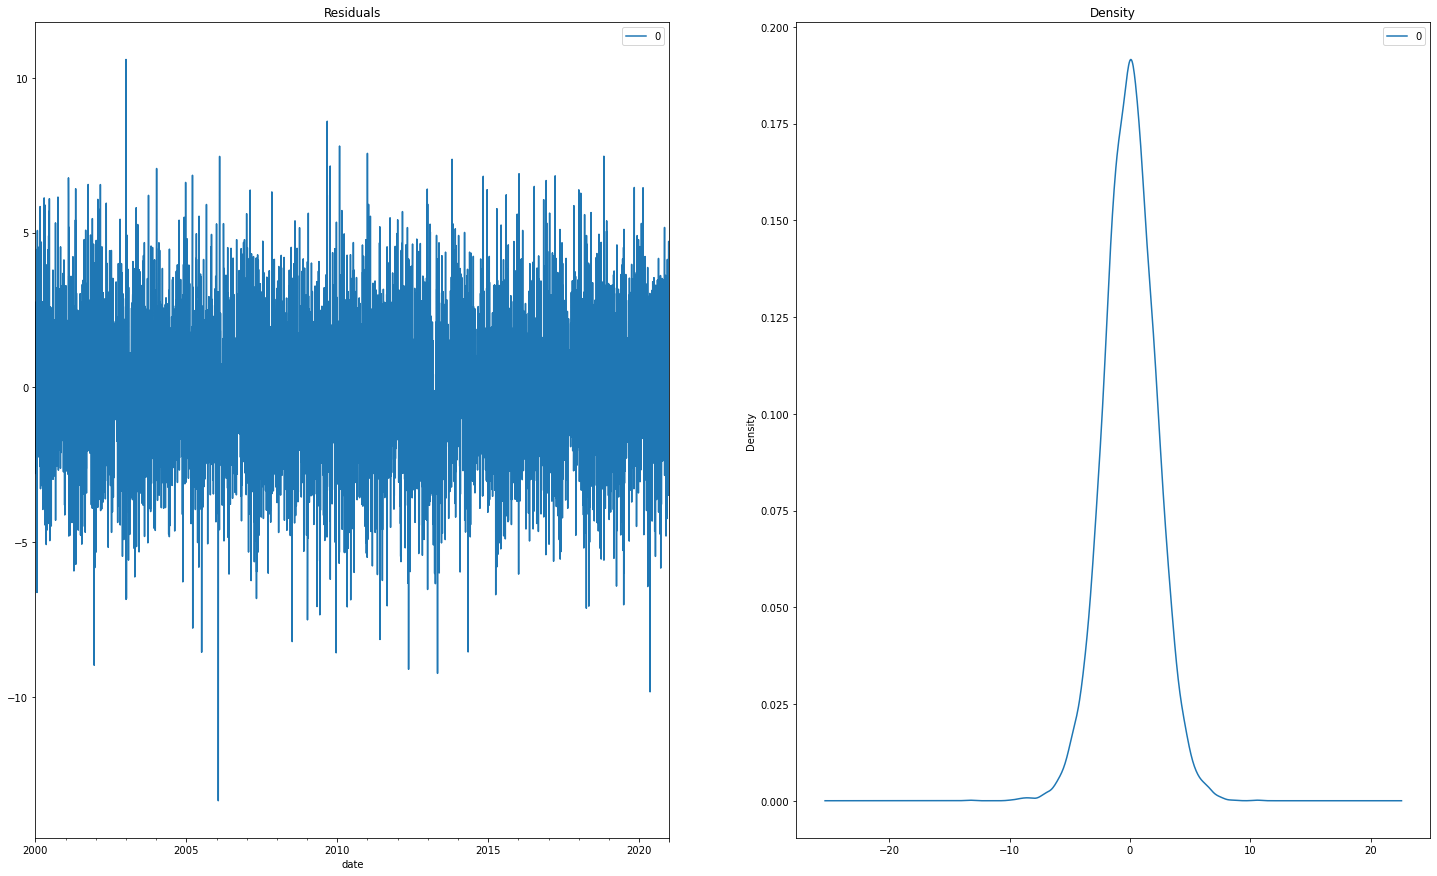

In [812]:
# Plot residual errors
residuals = pd.DataFrame(arima_model.resid)
fig, ax = plt.subplots(1,2, figsize=g_figsize)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

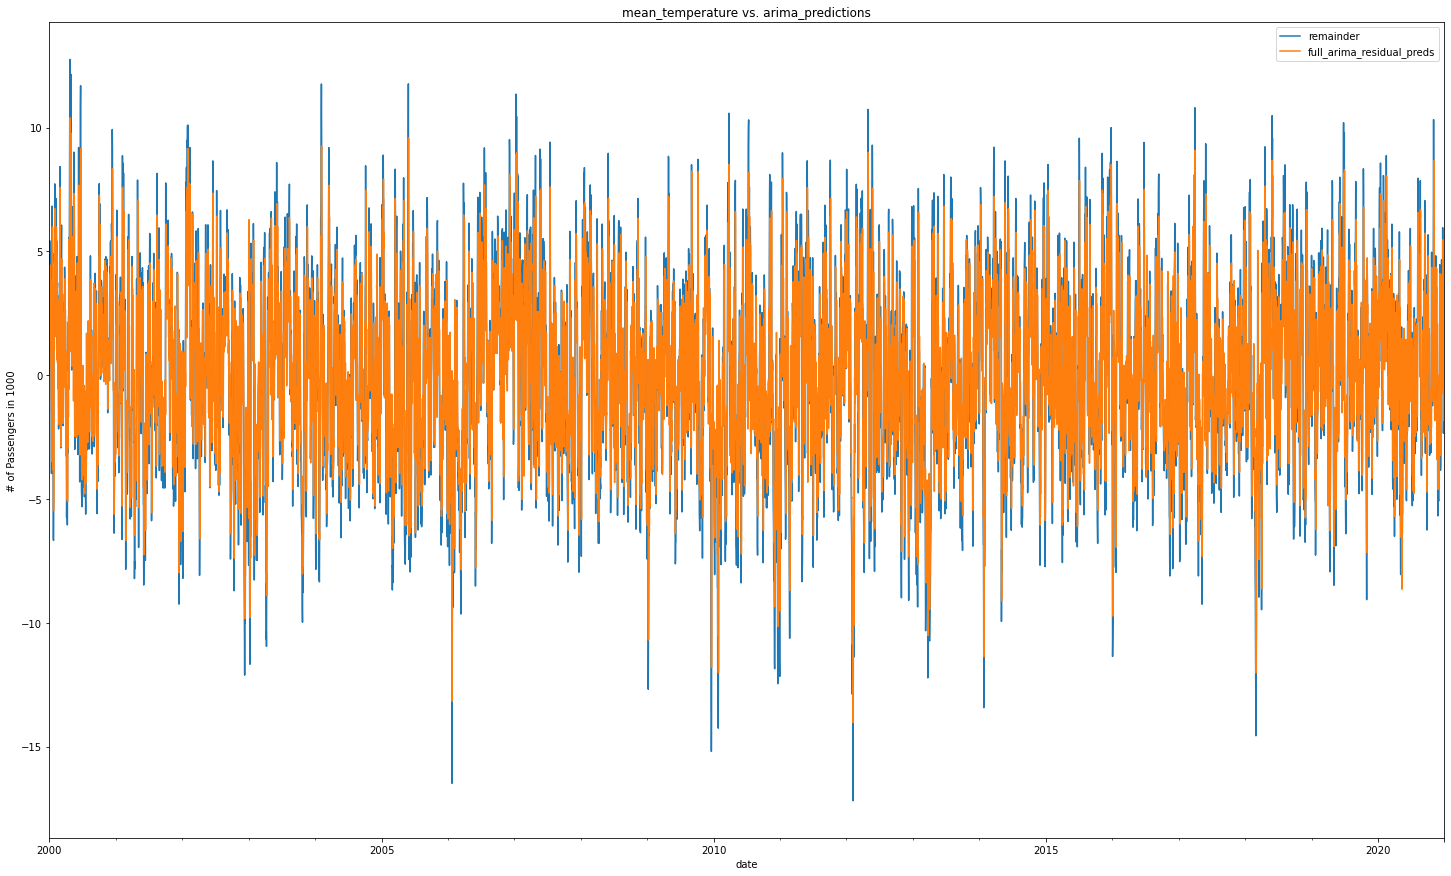

<AxesSubplot:title={'center':'mean_temperature vs. arima_predictions'}, xlabel='date', ylabel='# of Passengers in 1000'>

In [813]:
arima_remainder_preds = arima_model.predict(dynamic=False)
temp_df['full_arima_residual_preds'] = arima_remainder_preds
plot_data(temp_df[['remainder','full_arima_residual_preds']], title='mean_temperature vs. arima_predictions')

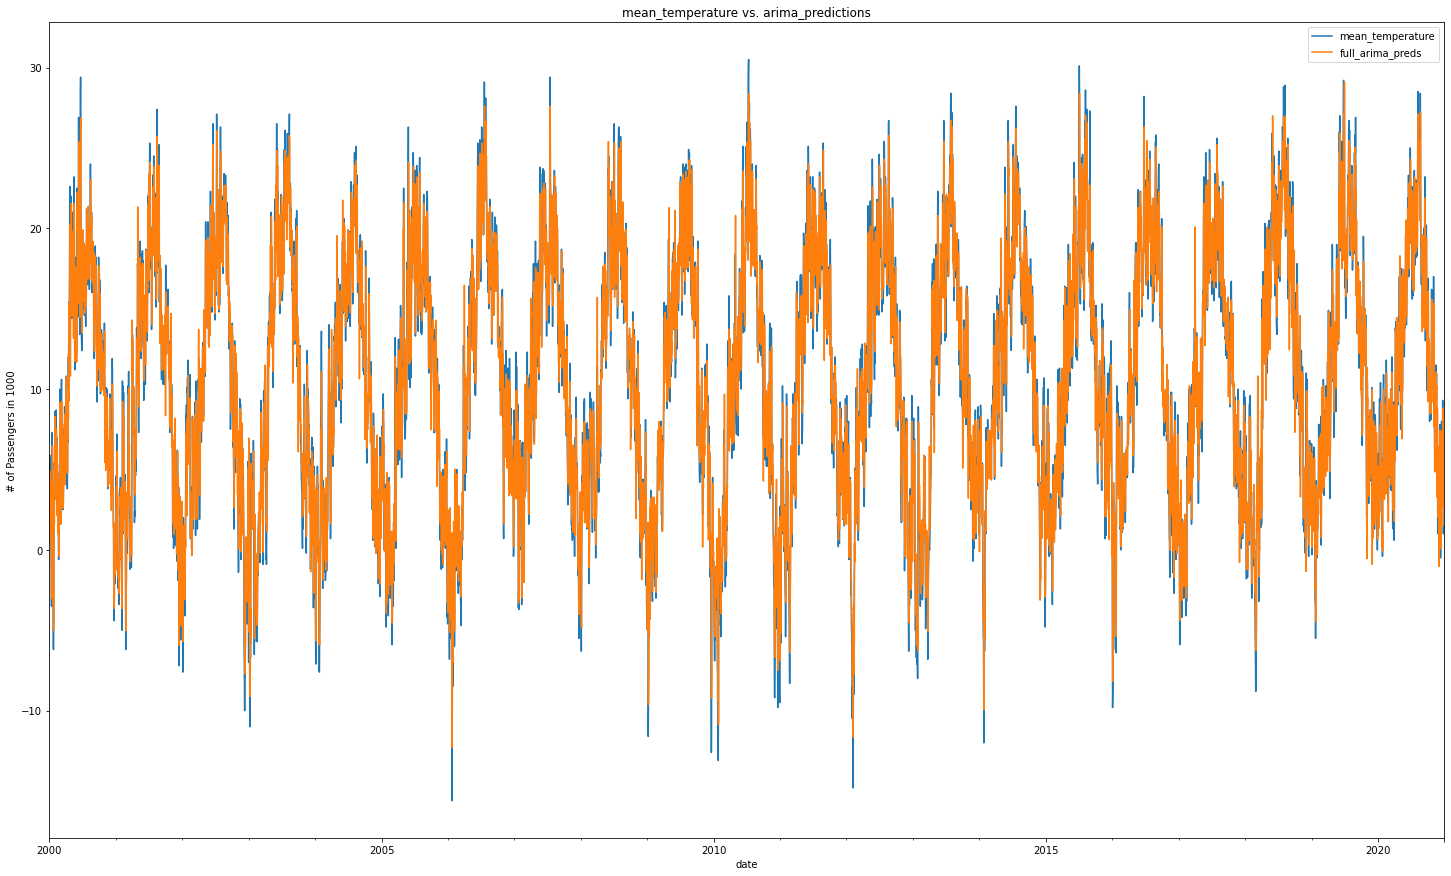

<AxesSubplot:title={'center':'mean_temperature vs. arima_predictions'}, xlabel='date', ylabel='# of Passengers in 1000'>

In [814]:
temp_df['full_arima_preds'] = temp_df['trend_seasonal'] + arima_remainder_preds
plot_data(temp_df[[target_label,'full_arima_preds']], title='mean_temperature vs. arima_predictions')

In [815]:
temp_df_test['arima_forecasted_remainder_values'] = arima_model.forecast(temp_df_test.index[-1])
confidence_intervals = arima_model.conf_int(alpha=0.05)
confidence_intervals



,0,1
const,-0.247903,0.248003
ar.L1,0.772445,0.828372
ma.L1,0.142195,0.214861
ma.L2,-0.135888,-0.062622
ma.L3,-0.099887,-0.043340
sigma2,4.640940,4.910024


In [816]:

# lower_series = pd.Series(confidence_intervals[:, 0], index=temp_df_test.index)
# upper_series = pd.Series(confidence_intervals[:, 1], index=temp_df_test.index)


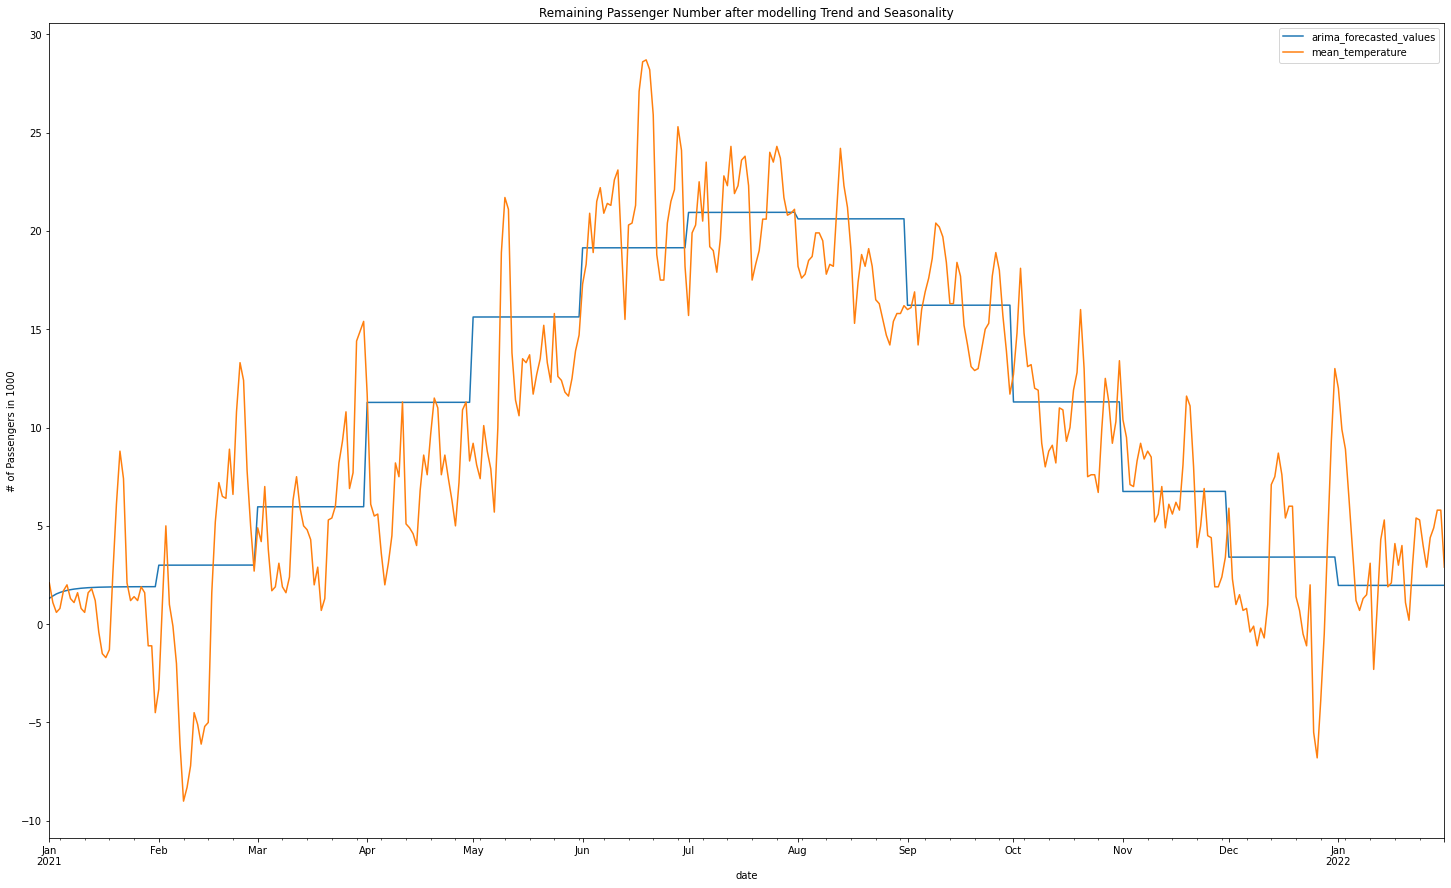

In [817]:

temp_df_test['arima_forecasted_values'] = temp_df_test['trend_seasonal'] + temp_df_test['arima_forecasted_remainder_values']


ax = plot_data(temp_df_test[['arima_forecasted_values', target_label]])
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15, ax=ax)



In [818]:

np.sqrt(mean_squared_error(temp_df_test['arima_forecasted_values'], temp_df_test[target_label]))


3.8755398034078476

In [819]:




# Make as pandas series
# fc_series = pd.Series(forecasts, index=temp_df_test.index)
# lower_series = pd.Series(confidence_intervals[:, 0], index=temp_df_test.index)
# upper_series = pd.Series(confidence_intervals[:, 1], index=temp_df_test.index)

# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(temp_df['remainder'], label='training')
# plt.plot(temp_df_test['remainder'], label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals remainder')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [820]:
# import pmdarima as pm
# from pmdarima.arima import StepwiseContext

# with StepwiseContext(max_dur=15):
#     auto_arima_model = pm.auto_arima(temp_df[target_label], 
#                     seasonal=True,
#                     m=365, 
#                     d=1,
#                     D=1, 
#                     stepwise=True,
#                     maxiter=1)
# auto_arima_model.summary()

In [821]:
# temp_df['full_autoarima_preds'] = auto_arima_model.predict_in_sample()
# plot_data(temp_df[['mean_temperature','full_autoarima_preds']], title='mean_temperature vs. auto_arima_predictions')


In [822]:
# import pickle

# # f = open("auto_arima_model.model", 'w')
# pickle.dump(auto_arima_model, open("auto_arima_model_91.model", 'wb'))


# y_forecast, ci = auto_arima_model.predict(len(temp_df_test.index), return_conf_int=True)

# temp_df_test['auto_arima_preds'] = y_forecast

# plot_data(temp_df_test[[target_label,'auto_arima_preds']], title='mean_temperature vs. arima_predictions')

